In [1]:
import numpy as np
import tensorflow as tf

from mrtoct import data

from matplotlib import pyplot as plt

transform = data.transform.DecodeExample()

def read_volume(path):
    return (tf.data.TFRecordDataset(path, 'GZIP')
            .map(transform)
            .make_one_shot_iterator()
            .get_next())

def mae(x, y):
    return np.abs(x - y).mean()

def psnr(x, y):
    max = np.iinfo(np.uint16).max
    mse = np.square(x - y).mean()
    
    return 20 * np.log10(max / np.sqrt(mse))

/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
training = {
    'inputs': read_volume('../data/tfrecord/training/mr.tfrecord'),
    'targets': read_volume('../data/tfrecord/training/ct.tfrecord'),
    'mae': read_volume('results/unet/mae/training.tfrecord'),
    'mae2a': read_volume('results/unet/mae2/training20542.tfrecord'),
    'mae2b': read_volume('results/unet/mae2/training22080.tfrecord'),
    'mae-gdl': read_volume('results/unet/mae-1e-7gdl/training.tfrecord'),
}

validation = {
    'inputs': read_volume('../data/tfrecord/validation/mr.tfrecord'),
    'targets': read_volume('../data/tfrecord/validation/ct.tfrecord'),
    'mae': read_volume('results/unet/mae/validation.tfrecord'),
    'mae2a': read_volume('results/unet/mae2/validation20542.tfrecord'),
    'mae2b': read_volume('results/unet/mae2/validation22080.tfrecord'),
    'mae-gdl': read_volume('results/unet/mae-1e-7gdl/validation.tfrecord'),
}

session = tf.Session()

In [7]:
mr_t, ct_t, mae_t, mae2a_t, mae2b_t, mae_gdl_t = session.run(list(training.values()))
mr_v, ct_v, mae_v, mae2a_v, mae2b_v, mae_gdl_v = session.run(list(validation.values()))

In [8]:
mr_t.shape, ct_t.shape, mae_t.shape

((161, 320, 250, 1), (161, 320, 250, 1), (161, 384, 384, 1))

In [9]:
def unpad(x, shape):
    height = np.abs(shape[1] - x.shape[1]) / 2
    width = np.abs(shape[2] - x.shape[2]) / 2
    
    start_h = int(np.floor(height))
    start_w = int(np.floor(width))

    end_h = - int(np.ceil(height))
    end_w = - int(np.ceil(width))
    
    return x[:, start_h:end_h, start_w:end_w]

In [10]:
mae_tr = unpad(mae_t, ct_t.shape)
mae2a_tr = unpad(mae2a_t, ct_t.shape)
mae2b_tr = unpad(mae2b_t, ct_t.shape)
mae_gdl_tr = unpad(mae_gdl_t, ct_t.shape)

mae_vr = unpad(mae_v, ct_v.shape)
mae2a_vr = unpad(mae2a_v, ct_v.shape)
mae2b_vr = unpad(mae2b_v, ct_v.shape)
mae_gdl_vr = unpad(mae_gdl_v, ct_v.shape)

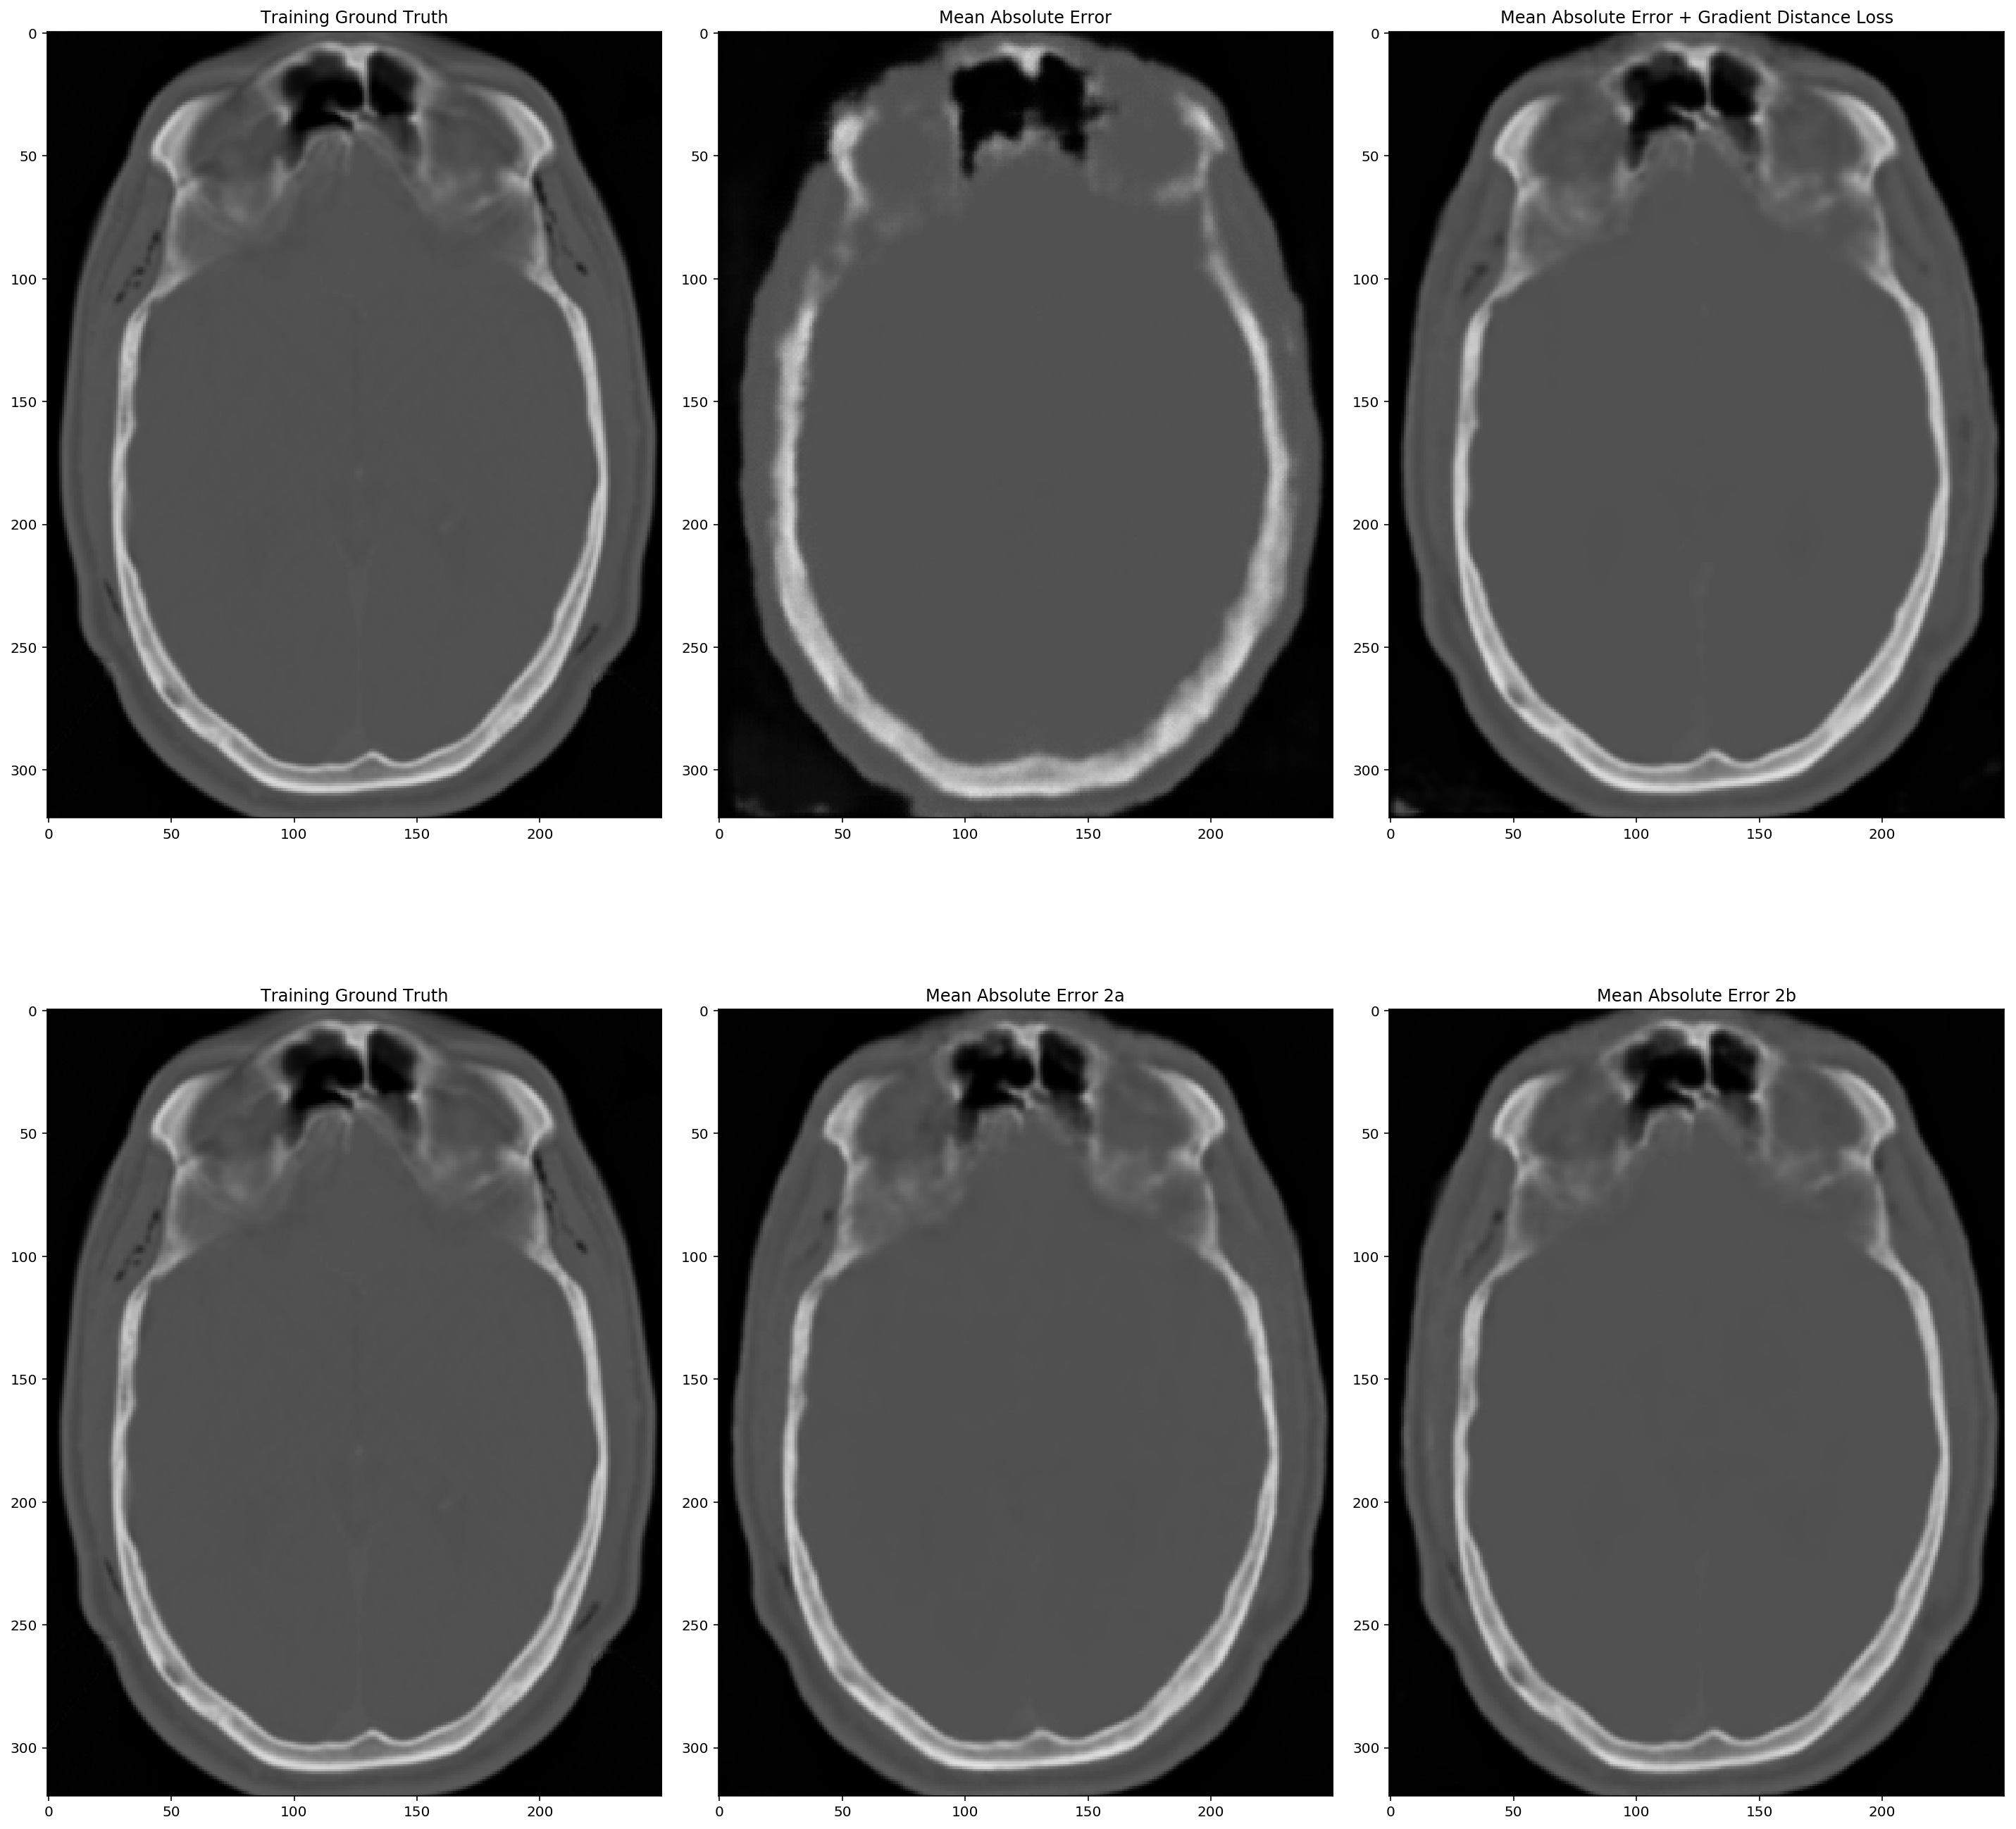

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(20, 20))

vmin = ct_t.min()
vmax = ct_t.max()

axes[0][0].set_title('Training Ground Truth')
axes[0][0].imshow(ct_t[100, :, :, 0], cmap='gray', vmin=vmin, vmax=vmax)

axes[0][1].set_title('Mean Absolute Error')
axes[0][1].imshow(mae_tr[100, :, :,0], cmap='gray', vmin=vmin, vmax=vmax)

axes[0][2].set_title('Mean Absolute Error + Gradient Distance Loss')
axes[0][2].imshow(mae_gdl_tr[100, :, :,0], cmap='gray', vmin=vmin, vmax=vmax)

axes[1][0].set_title('Training Ground Truth')
axes[1][0].imshow(ct_t[100, :, :, 0], cmap='gray', vmin=vmin, vmax=vmax)

axes[1][1].set_title('Mean Absolute Error 2a')
axes[1][1].imshow(mae2a_tr[100, :, :,0], cmap='gray', vmin=vmin, vmax=vmax)

axes[1][2].set_title('Mean Absolute Error 2b')
axes[1][2].imshow(mae2b_tr[100, :, :,0], cmap='gray', vmin=vmin, vmax=vmax)


fig.tight_layout()
plt.show()

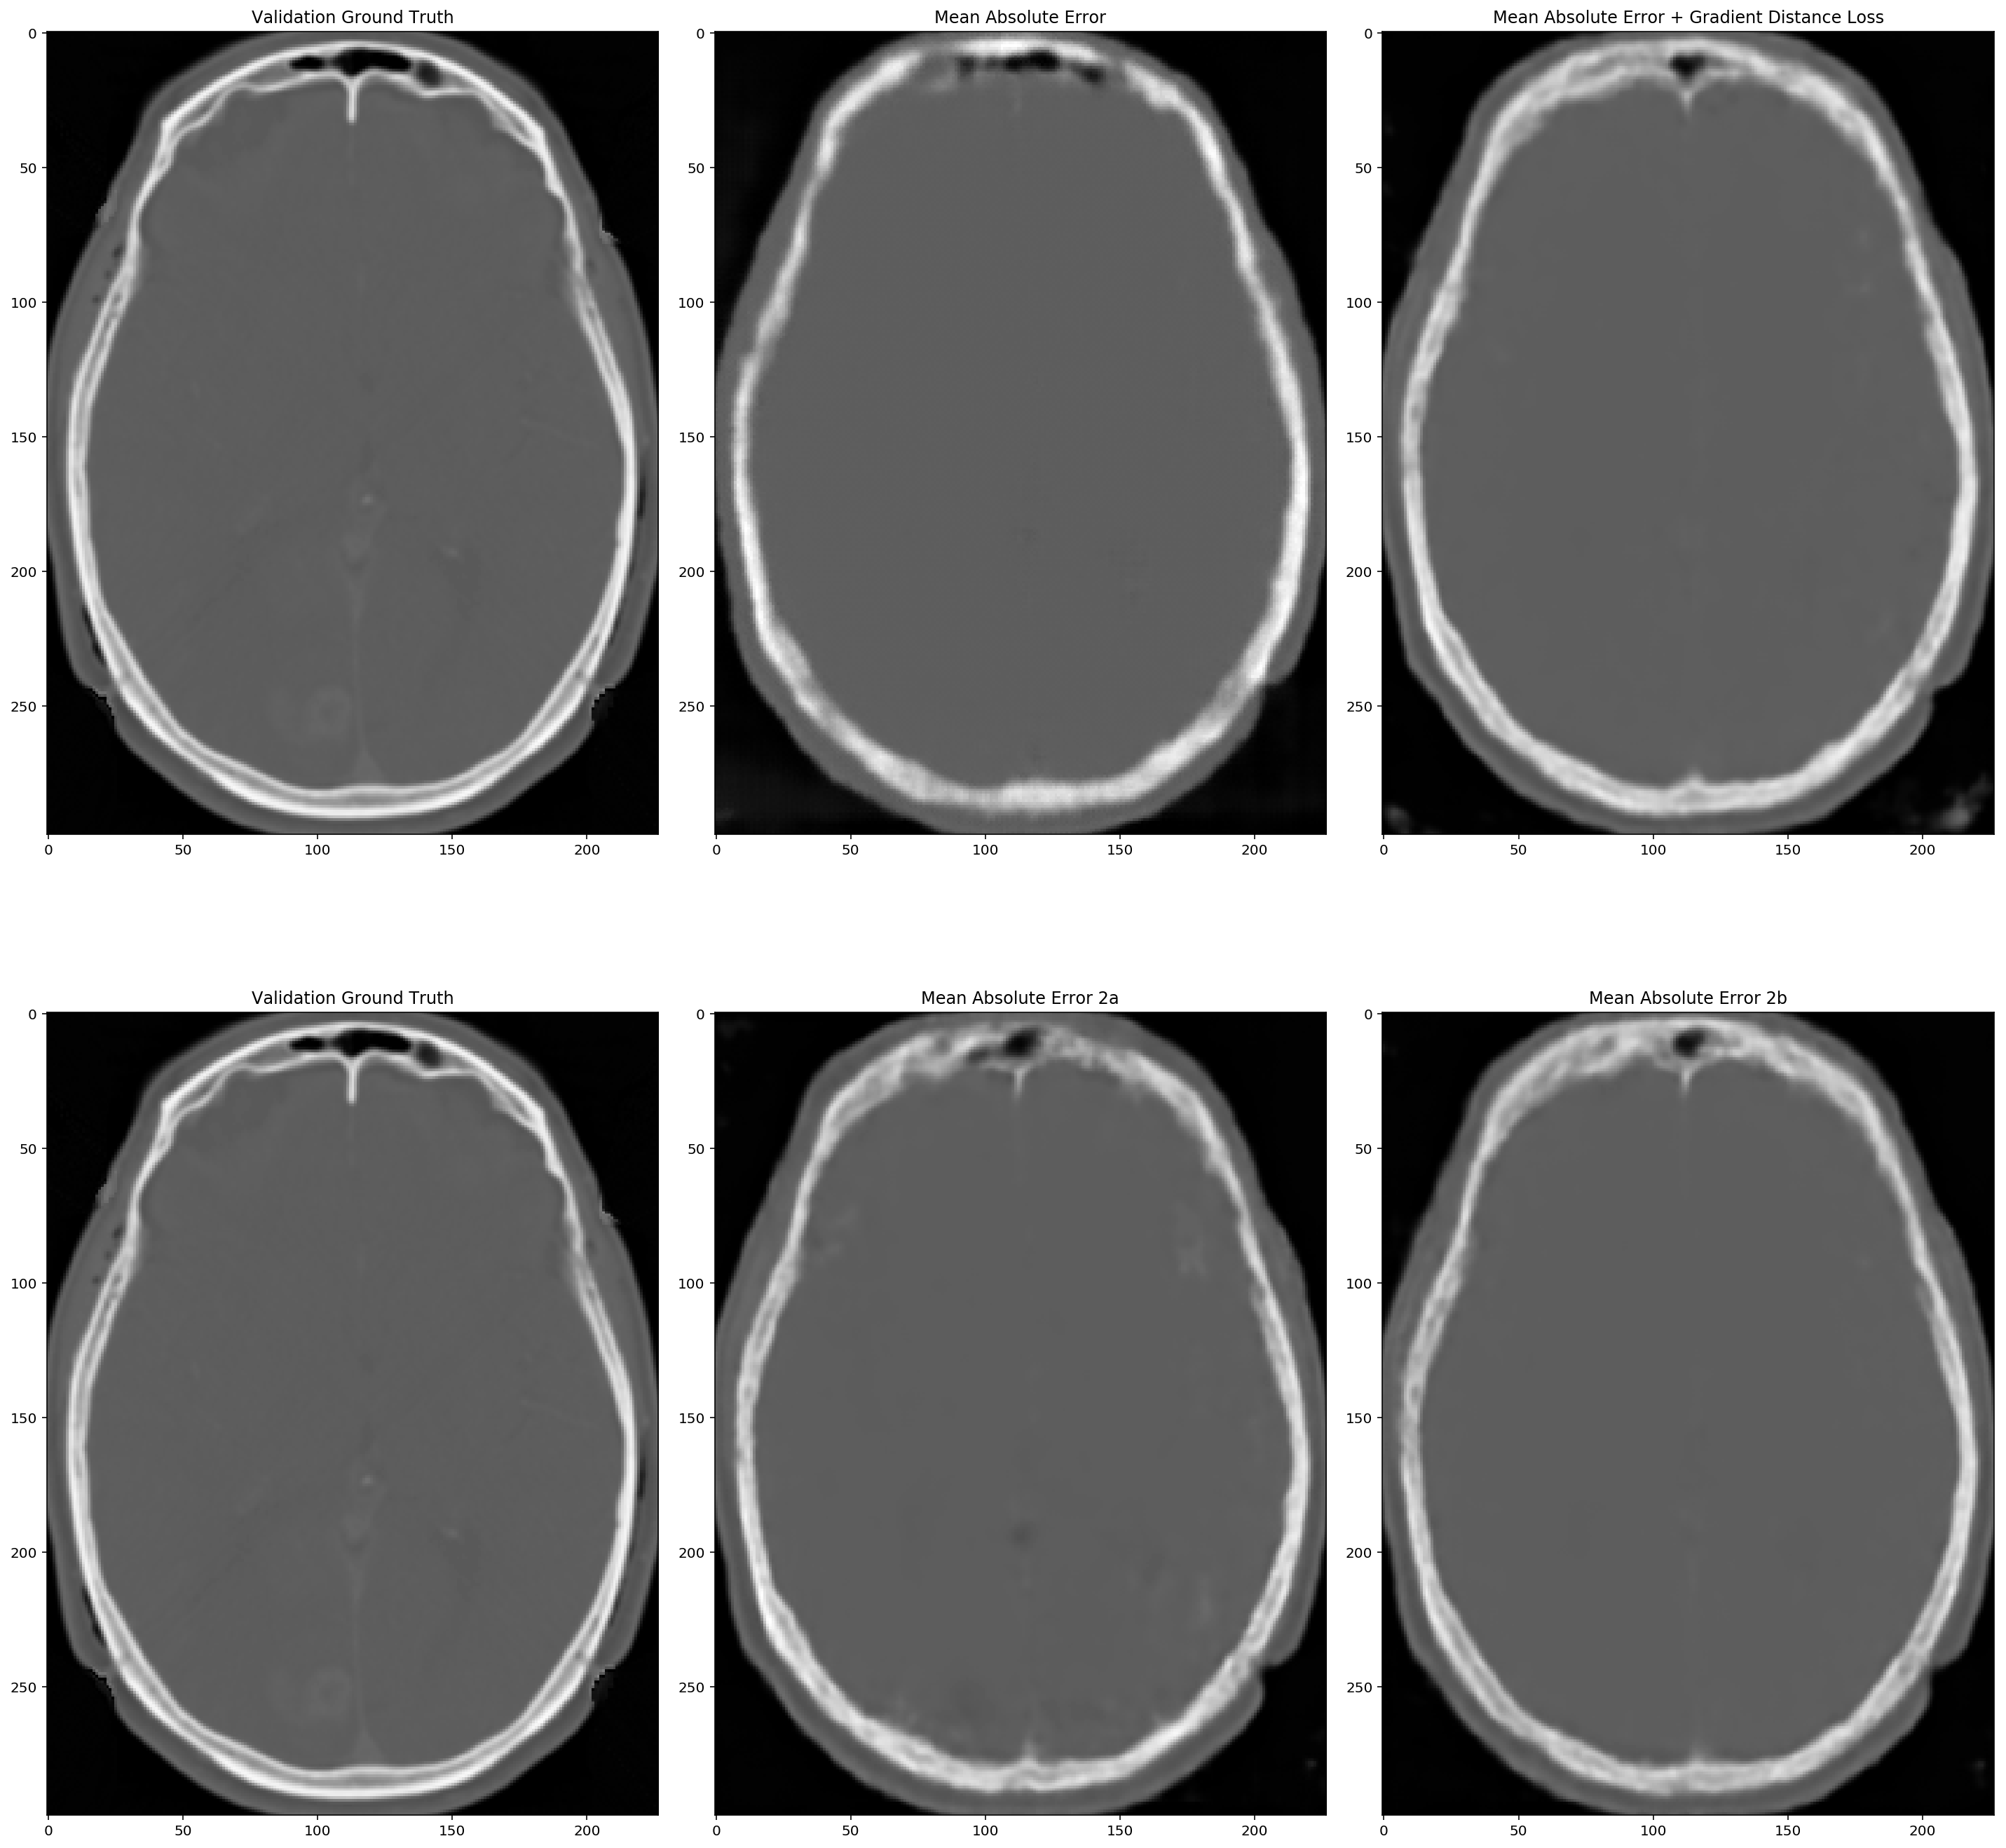

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(20, 20))

vmin = ct_v.min()
vmax = ct_v.max()

axes[0][0].set_title('Validation Ground Truth')
axes[0][0].imshow(ct_v[100, :, :, 0], cmap='gray', vmin=vmin, vmax=vmax)

axes[0][1].set_title('Mean Absolute Error')
axes[0][1].imshow(mae_vr[100, :, :,0], cmap='gray', vmin=vmin, vmax=vmax)

axes[0][2].set_title('Mean Absolute Error + Gradient Distance Loss')
axes[0][2].imshow(mae_gdl_vr[100, :, :,0], cmap='gray', vmin=vmin, vmax=vmax)

axes[1][0].set_title('Validation Ground Truth')
axes[1][0].imshow(ct_v[100, :, :, 0], cmap='gray', vmin=vmin, vmax=vmax)

axes[1][1].set_title('Mean Absolute Error 2a')
axes[1][1].imshow(mae2a_vr[100, :, :,0], cmap='gray', vmin=vmin, vmax=vmax)

axes[1][2].set_title('Mean Absolute Error 2b')
axes[1][2].imshow(mae2b_vr[100, :, :,0], cmap='gray', vmin=vmin, vmax=vmax)

fig.tight_layout()
plt.show()

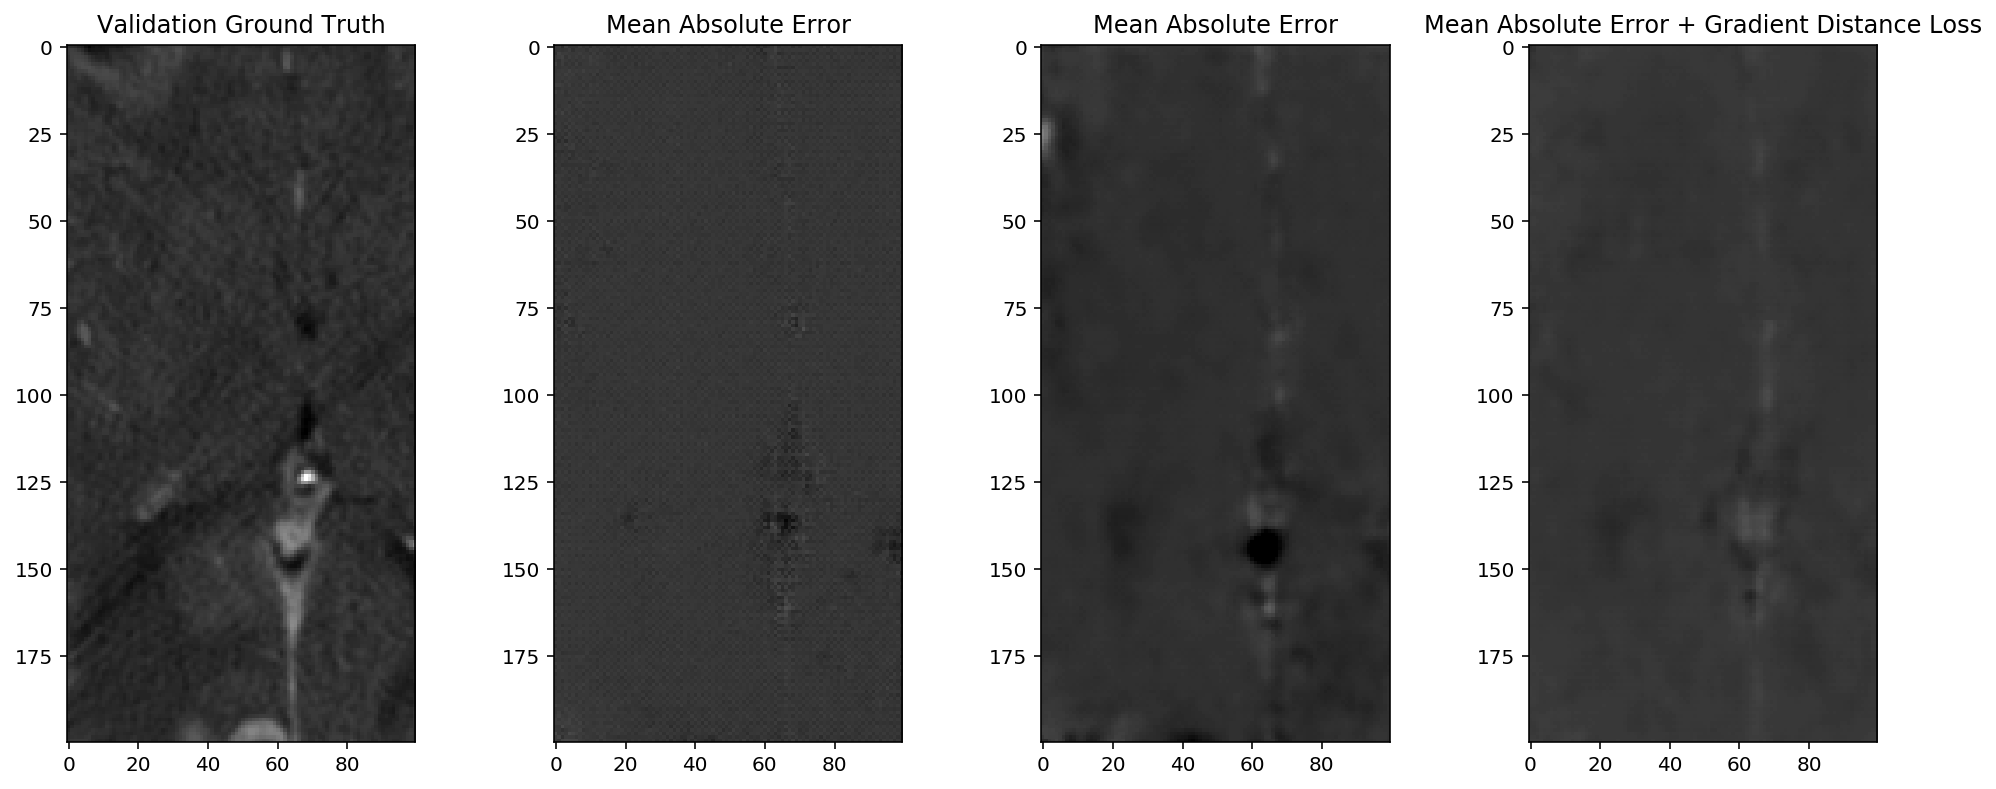

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(14, 20))

vmin = ct_v[100, 50:250, 50:150, 0].min()
vmax = ct_v[100, 50:250, 50:150, 0].max()

axes[0].set_title('Validation Ground Truth')
axes[0].imshow(ct_v[100, 50:250, 50:150, 0], cmap='gray', vmin=vmin, vmax=vmax)

axes[1].set_title('Mean Absolute Error')
axes[1].imshow(mae_vr[100, 50:250, 50:150, 0], cmap='gray', vmin=vmin, vmax=vmax)

axes[2].set_title('Mean Absolute Error')
axes[2].imshow(mae2a_vr[100, 50:250, 50:150, 0], cmap='gray', vmin=vmin, vmax=vmax)

axes[3].set_title('Mean Absolute Error + Gradient Distance Loss')
axes[3].imshow(mae_gdl_vr[100, 50:250, 50:150, 0], cmap='gray', vmin=vmin, vmax=vmax)

fig.tight_layout()
plt.show()

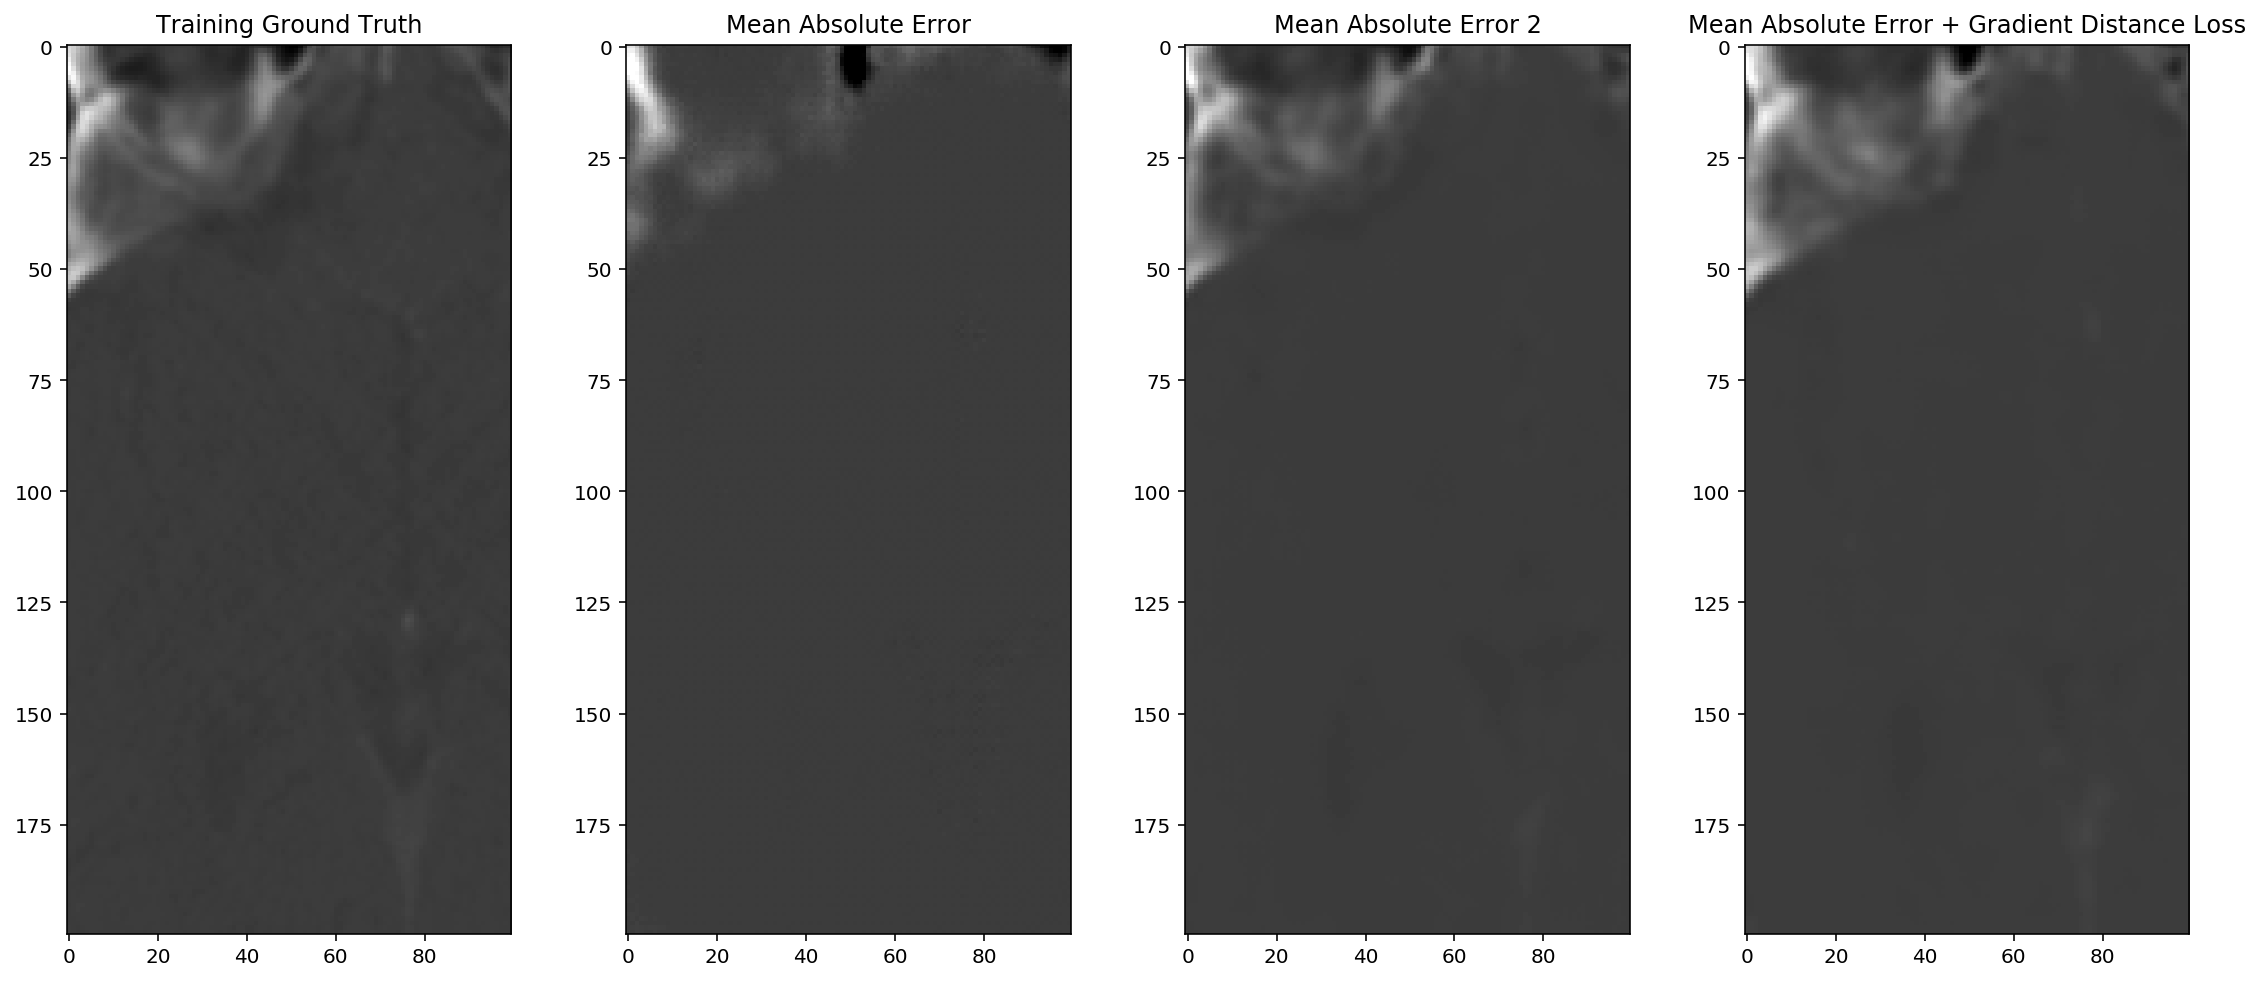

In [19]:
fig, axes = plt.subplots(1, 4, figsize=(16, 20))

vmin = ct_t[100, 50:250, 50:150, 0].min()
vmax = ct_t[100, 50:250, 50:150, 0].max()

axes[0].set_title('Training Ground Truth')
axes[0].imshow(ct_t[100, 50:250, 50:150, 0], cmap='gray', vmin=vmin, vmax=vmax)

axes[1].set_title('Mean Absolute Error')
axes[1].imshow(mae_tr[100, 50:250, 50:150, 0], cmap='gray', vmin=vmin, vmax=vmax)

axes[2].set_title('Mean Absolute Error 2')
axes[2].imshow(mae2b_tr[100, 50:250, 50:150, 0], cmap='gray', vmin=vmin, vmax=vmax)

axes[3].set_title('Mean Absolute Error + Gradient Distance Loss')
axes[3].imshow(mae_gdl_tr[100, 50:250, 50:150, 0], cmap='gray', vmin=vmin, vmax=vmax)

fig.tight_layout()
plt.show()

In [24]:
mae_t_mae= []
mae_t_psnr = []

mae2b_t_mae= []
mae2b_t_psnr = []

mae_gdl_t_mae = []
mae_gdl_t_psnr = []

try:
    while True:
        mr_t, ct_t, mae_t, mae2a_t, mae2b_t, mae_gdl_t = session.run(list(training.values()))
    
        mae_tr = unpad(mae_t, ct_t.shape)
        mae2b_tr = unpad(mae2b_t, ct_t.shape)
        mae_gdl_tr = unpad(mae_gdl_t, ct_t.shape)
    
        mae_t_mae.append(mae(mae_tr, ct_t))
        mae_t_psnr.append(psnr(mae_tr, ct_t))
    
        mae2b_t_mae.append(mae(mae2b_tr, ct_t))
        mae2b_t_psnr.append(psnr(mae2b_tr, ct_t))
    
        mae_gdl_t_mae.append(mae(mae_gdl_tr, ct_t))
        mae_gdl_t_psnr.append(psnr(mae_gdl_tr, ct_t))
except:
    pass

In [33]:
mae_v_mae= []
mae_v_psnr = []

mae2b_v_mae= []
mae2b_v_psnr = []

mae_gdl_v_mae = []
mae_gdl_v_psnr = []

while True:
    mr_v, ct_v, mae_v, mae2a_v, mae2b_v, mae_gdl_v = session.run(list(validation.values()))
    
    mae_vr = unpad(mae_v, ct_v.shape)
    mae2b_vr = unpad(mae2b_v, ct_v.shape)
    mae_gdl_vr = unpad(mae_gdl_v, ct_v.shape)
    
    mae_v_mae.append(mae(mae_vr, ct_v))
    mae_v_psnr.append(psnr(mae_vr, ct_v))
    
    mae2b_v_mae.append(mae(mae2b_vr, ct_v))
    mae2b_v_psnr.append(psnr(mae2b_vr, ct_v))
    
    mae_gdl_v_mae.append(mae(mae_gdl_vr, ct_v))
    mae_gdl_v_psnr.append(psnr(mae_gdl_vr, ct_v))

OutOfRangeError: End of sequence
	 [[Node: IteratorGetNext_70 = IteratorGetNext[output_shapes=[<unknown>], output_types=[DT_INT32], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator_70)]]

Caused by op 'IteratorGetNext_70', defined at:
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-2a6c61e05e9b>", line 15, in <module>
    'mae2b': read_volume('results/unet/mae2/validation22080.tfrecord'),
  File "<ipython-input-31-630f3155f537>", line 12, in read_volume
    .map(transform)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 259, in get_next
    name=name))
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 706, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

OutOfRangeError (see above for traceback): End of sequence
	 [[Node: IteratorGetNext_70 = IteratorGetNext[output_shapes=[<unknown>], output_types=[DT_INT32], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator_70)]]


In [34]:
for i, mae in enumerate(mae_v_mae):
    print(f'Mean Absolute Error (MAE, Validation Patient {i})', mae)
print('Mean Absolute Error (MAE, Validation Mean)', np.mean(mae_v_mae))
print('')

for i, psnr in enumerate(mae_v_psnr):
    print(f'Mean Absolute Error (PSNR Validation Patient {i})', psnr)
print('Mean Absolute Error (PSNR, Validation Mean)', np.mean(mae_v_psnr))
print('')

for i, mae in enumerate(mae2b_v_mae):
    print(f'Mean Absolute Error 2b (MAE, Validation Patient {i})', mae)
print('Mean Absolute Error (MAE, Validation Mean)', np.mean(mae2b_v_mae))
print('')

for i, psnr in enumerate(mae2b_v_psnr):
    print(f'Mean Absolute Error 2b (PSNR Validation Patient {i})', psnr)
print('Mean Absolute Error (PSNR, Validation Mean)', np.mean(mae2b_v_psnr))
print('')

for i, mae in enumerate(mae_gdl_v_mae):
    print(f'Mean Absolute Error + Gradient Distance Loss (MAE, Validation Patient {i})', mae)
print('Mean Absolute Error + Gradient Distance Loss (MAE, Validation Mean)', np.mean(mae_gdl_v_mae))
print('')

for i, psnr in enumerate(mae_gdl_v_psnr):
    print(f'Mean Absolute Error + Gradient Distance Loss (PSNR Validation Patient {i})', psnr)
print('Mean Absolute Error + Gradient Distance Loss (PSNR, Validation Mean)', np.mean(mae_gdl_v_psnr))

Mean Absolute Error (MAE, Validation Patient 0) 109.882324897
Mean Absolute Error (MAE, Validation Patient 1) 133.352291758
Mean Absolute Error (MAE, Validation Patient 2) 145.264726622
Mean Absolute Error (MAE, Validation Patient 3) 147.54936463
Mean Absolute Error (MAE, Validation Mean) 134.012176977

Mean Absolute Error (PSNR Validation Patient 0) 48.7053392526
Mean Absolute Error (PSNR Validation Patient 1) 47.2832907093
Mean Absolute Error (PSNR Validation Patient 2) 46.8194620685
Mean Absolute Error (PSNR Validation Patient 3) 46.7430338086
Mean Absolute Error (PSNR, Validation Mean) 47.3877814598

Mean Absolute Error 2b (MAE, Validation Patient 0) 85.0220493979
Mean Absolute Error 2b (MAE, Validation Patient 1) 145.778839061
Mean Absolute Error 2b (MAE, Validation Patient 2) 146.842477596
Mean Absolute Error 2b (MAE, Validation Patient 3) 147.825045756
Mean Absolute Error (MAE, Validation Mean) 131.367102953

Mean Absolute Error 2b (PSNR Validation Patient 0) 49.9857275446
Mean 

In [26]:
for i, mae in enumerate(mae_t_mae):
    print(f'Mean Absolute Error (MAE, Training Patient {i})', mae)
print('Mean Absolute Error (MAE, Training Mean)', np.mean(mae_t_mae))
print('')

for i, psnr in enumerate(mae_t_psnr):
    print(f'Mean Absolute Error (PSNR Training Patient {i})', psnr)
print('Mean Absolute Error (PSNR, Training Mean)', np.mean(mae_t_psnr))
print('')

for i, mae in enumerate(mae2b_t_mae):
    print(f'Mean Absolute Error 2b (MAE, Training Patient {i})', mae)
print('Mean Absolute Error (MAE, Training Mean)', np.mean(mae2b_t_mae))
print('')

for i, psnr in enumerate(mae2b_t_psnr):
    print(f'Mean Absolute Error 2b (PSNR Training Patient {i})', psnr)
print('Mean Absolute Error (PSNR, Training Mean)', np.mean(mae2b_t_psnr))
print('')

for i, mae in enumerate(mae_gdl_t_mae):
    print(f'Mean Absolute Error + Gradient Distance Loss (MAE, Training Patient {i})', mae)
print('Mean Absolute Error + Gradient Distance Loss (MAE, Training Mean)', np.mean(mae_gdl_t_mae))
print('')

for i, psnr in enumerate(mae_gdl_t_psnr):
    print(f'Mean Absolute Error + Gradient Distance Loss (PSNR Training Patient {i})', psnr)
print('Mean Absolute Error + Gradient Distance Loss (PSNR, Training Mean)', np.mean(mae_gdl_t_psnr))

Mean Absolute Error (MAE, Training Patient 0) 103.659822802
Mean Absolute Error (MAE, Training Patient 1) 94.957903699
Mean Absolute Error (MAE, Training Patient 2) 102.390042111
Mean Absolute Error (MAE, Training Patient 3) 89.8621859972
Mean Absolute Error (MAE, Training Patient 4) 99.6911341148
Mean Absolute Error (MAE, Training Patient 5) 91.1769091179
Mean Absolute Error (MAE, Training Patient 6) 85.1124818266
Mean Absolute Error (MAE, Training Patient 7) 71.638921021
Mean Absolute Error (MAE, Training Patient 8) 105.312068682
Mean Absolute Error (MAE, Training Patient 9) 107.262014002
Mean Absolute Error (MAE, Training Patient 10) 94.4191024554
Mean Absolute Error (MAE, Training Patient 11) 119.753594129
Mean Absolute Error (MAE, Training Mean) 97.1030149966

Mean Absolute Error (PSNR Training Patient 0) 49.2118143211
Mean Absolute Error (PSNR Training Patient 1) 50.2377848059
Mean Absolute Error (PSNR Training Patient 2) 48.8954939329
Mean Absolute Error (PSNR Training Patient 3

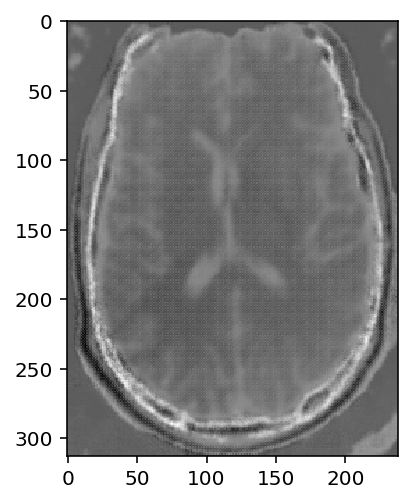

In [130]:
plt.imshow(mae_tr[50,:,:,0], cmap='gray')

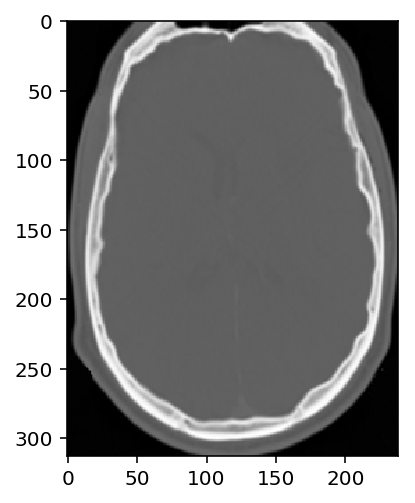

In [132]:
plt.imshow(ct_t[50,:,:,0], cmap='gray')

In [16]:
ct_t.shape

(112, 313, 238, 1)

In [17]:
mr_t.shape

(112, 313, 238, 1)

In [39]:
a = np.abs(ct_t - mae2b_tr)
b = np.abs(ct_t - mae_gdl_tr)

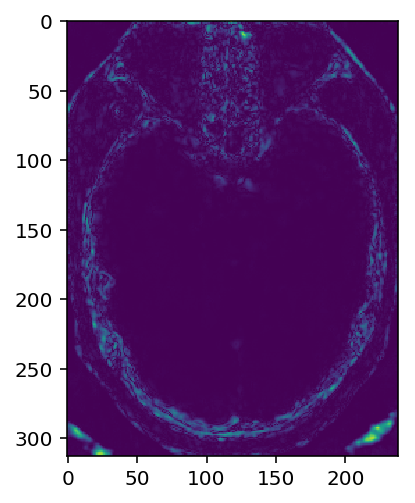

In [40]:
plt.imshow(np.abs(a-b)[100,:,:,0])

In [6]:
training_slices = 0

while True:
    mr = session.run(list(training.values())[0])

    training_slices += mr.shape[0]

training_slices

OutOfRangeError: End of sequence
	 [[Node: IteratorGetNext_12 = IteratorGetNext[output_shapes=[<unknown>], output_types=[DT_INT32], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator_12)]]

Caused by op 'IteratorGetNext_12', defined at:
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 281, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 232, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 397, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-1509c78cff9c>", line 2, in <module>
    'inputs': read_volume('../data/tfrecord/training/mr.tfrecord'),
  File "<ipython-input-1-630f3155f537>", line 12, in read_volume
    .map(transform)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 259, in get_next
    name=name))
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 706, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/Cellar/pyenv/1.2.0/versions/3.6.3/envs/mrtoct/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

OutOfRangeError (see above for traceback): End of sequence
	 [[Node: IteratorGetNext_12 = IteratorGetNext[output_shapes=[<unknown>], output_types=[DT_INT32], _device="/job:localhost/replica:0/task:0/device:CPU:0"](OneShotIterator_12)]]


In [7]:
training_slices

2157